# QNN with MyQLM
## By Todor Krasimirov Ivanov

## 1. Problem definition

The main point is to train a Quantum Neural Network to be capable of predicting the output values of the following function $f(x)$ given a real input $x \in [0,1]$.

$f(x) = -\sin(10x) + 3\cos(18x) - 8(x-1/2)^2 + 5/4$

After this, the second goal is to use the trained QNN model to find the maximum value of said function by using a classical optimizer.

## 2. Analysis and specifications

Before diving into the solution, let's point out some relevant considerations.

- All the challenge is carried out in the computational basis $\{0,1\}$, i.e. the Pauli Z basis which is defined as $\sigma_Z = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}$ and whose eigenstates are $\left|0 \right\rangle$ and $\left|1 \right\rangle$ with $1$ and $-1$ eigenvalues respectively.


- The quantum circuit is constructed as it is suggested in the challenge description, this is, using only CNOT and X and Y single-qubit rotation gates and with 5 free parameters per qubit.


- The training dataset is made of 50 random samples of the function $f(x)$


- The testing dataset is made of other 20 random samples of the function $f(x)$.


- The function to be used for the loss function minimization is _scipy.optimize.minimize_. It is also used for the target function $f(x)$ maximization via the _basinhopping_ function to avoid local maxima but negating the outcome of the expectation value so the minimization method turns into a maximization in practical terms. L-BFGS-B from SciPy library with default settings is the optimizer method employed for the training. The settings of the SciPy method embed some machine learning features like the number of epochs realized for a given convergence, the learning rate of the model...


- The loss function will be Mean Square Error:

    $MSE = \frac{1}{N} \sum_{i=1}^{N} (y_i - \tilde{y_i})^2$



## 3. Python requirements and imports

The libraries used for the QNN implementation are myqlm, numpy, scipy and matplotlib that can be installed with the following command and the needed modules are imported in the next one.

In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install myqlm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from functools import partial
from qat.lang import qfunc, qrout, RX, RY, CNOT
import time

## 4. Dataset methods

Here, we provide the necessary methods to create the dataset of the target function $f(x)$.

In [3]:
def target_function(x):
    ''' 
    Evaluates the target function in the input value point
    
    :param x: Independent variable value
    :return: Function evaluation result of the input value
    '''
    return -np.sin(10*x) + 3*np.cos(18*x) - 8*((x-1/2)**2) + 5/4

def normalize(values):
    '''
    Normalizes the input values to the range [-0.5, 0.5] depending on the
    existing maximum and minimum values.
    
    :param values: Array of values to be normalized
    '''
    max_val = np.max(values)
    min_val = np.min(values)
    norm_factor = max_val - min_val
    return values / norm_factor, norm_factor

def generate_random_dataset(num_samples, lower_bound, upper_bound):
    '''
    Creates a random dataset of the target function given the number of samples
    desired and the range where the domain is defined.
    
    :param num_samples: Number of rows in the dataset
    :param lower_bound: Lowest possible value of the input domain
    :param upper_bound: Highest possible value of the input domain
    :return: Tuples of input-output of the target function
    '''
    inputs = np.random.uniform(low=lower_bound, high=upper_bound, size=(num_samples))
    
    outputs = np.array([target_function(inp) for inp in inputs])
    outputs, norm_factor = normalize(outputs)
    
    return inputs, outputs, norm_factor

def generate_linear_dataset(num_samples, lower_bound, upper_bound):
    '''
    Creates a linear dataset of the target function given the number of samples
    desired and the range where the domain is defined.
    
    :param num_samples: Number of rows in the dataset
    :param lower_bound: Lowest possible value of the input domain
    :param upper_bound: Highest possible value of the input domain
    :return: Tuples of input-output of the target function
    '''
    inputs = np.linspace(lower_bound, upper_bound, num_samples)
    
    outputs = np.array([target_function(inp) for inp in inputs])
    outputs, norm_factor = normalize(outputs)
    
    return inputs, outputs, norm_factor

## 5. Quantum neural network model training

### 5.1. QNN methods

The following methods are the necessary ones to build, train and evaluate the QNN: construction of the quantum circuit, computation of the expectation value of a quantum circuit, evaluation and training of the QNN model.

In [4]:
def prepare_input(x, N_qubits):
    inp = np.zeros((N_qubits))
    for idx in range(N_qubits):
        inp[idx] = 2*(idx+1)*np.arcsin(x)
    return inp

@qrout(unroll=False)
def qnn(parameters, x, N_qubits):
    qubit_parameters = parameters.reshape((N_qubits, 5))
    # Input data loading
    for idx in range(N_qubits):
        RX(x[idx])(idx)
    # First parameterized part of the QNN
    for idx in range(N_qubits):
        RY(qubit_parameters[idx, 0])(idx)
        RX(qubit_parameters[idx, 1])(idx)
    # Apply CNOTs in cascade
    for idx in range(N_qubits - 1):
        CNOT(idx, idx + 1)
    # Second parameterized part of the QNN
    for idx in range(N_qubits):
        RY(qubit_parameters[idx, 2])(idx)
        RX(qubit_parameters[idx, 3])(idx)
        RY(qubit_parameters[idx, 4])(idx)
    # Apply CNOTs in cascade
    for idx in range(N_qubits - 1):
        CNOT(idx, idx + 1)

In [5]:
def evaluate_qnn(x, parameters, N_qubits, observable):
    '''
    Builds the circuit with the provided parameters related to the QNN 
    calculating the expectation value of the given observable.
    
    :param x: Input value of the QNN
    :param parameters: Tunable parameters of the QNN
    :param N_qubits: Number of qubits in the quantum circuit of the QNN
    :param observable: Observable whose expectation value is to be calculated at the end of the circuit
    :return: Expectation value of the observable over the final state of the circuit
    '''
    inputs = prepare_input(x, N_qubits)
    qcirc = qnn(parameters, inputs, N_qubits)
    job = qcirc.to_job()
    result = job.run()

    # Build the tensor product of observables
    observs = 1
    for i in range(N_qubits):
        observs = np.kron(observable, observs)

    # Compute the expectation value of the observable for each qubit
    outcome = np.real_if_close(result.statevector.conj().T @ observs @ result.statevector)
    
    return outcome

def train_qnn(parameters, input_set, output_set, N_qubits, observable):
    '''
    Method to be optimized where the loss function (MSE) value is computed 
    comparing the expected outcomes with those obtained by the QNN.
    
    :param parameters: QNN parameters to be tuned
    :param input_set: Array of input values whose indices are related to output_set
    :param output_set: Array of output values whose indices are related to input_set
    :param N_qubits: Number of qubits in the quantum circuit of the QNN
    :param observable: The observable whose expectation value is going to be computed for the QNN output
    :return: Mean square error of the desired and obtained results
    '''
    dataset_length = len(input_set)
    mse = 0
    
    for sample in range(dataset_length):
        x = input_set[sample]
        
        expected_output = output_set[sample]
        obtained_output = evaluate_qnn(x, parameters, N_qubits, observable)
        
        mse += (expected_output - obtained_output)**2
    
    return mse/dataset_length

def callback_train_qnn(xk):
    '''
    Stores model's loss for every epoch in the optimization.
    
    :param xk: Current values of tunable parameters
    '''
    e = loss_function(xk)
    loss_values.append(e)

### 5.2. QNN training script
Next, we have the main script where the necessary elements for the QNN model training are defined and the optimization process is performed.

The values of the loss function obtained through the QNN training process are plotted at the end.

In [6]:
# Define the number of qubits and free parameters per qubit of the QNN
N_qubits = 4
pars_per_qubit = 5

# Create a dataset of the target function with the corresponding range and number of samples
dataset_size = 150
lower_bound = 0
upper_bound = 1
input_set, output_set, dataset_norm = generate_random_dataset(dataset_size, lower_bound, upper_bound)

# Define the observable for the expectation value
observable = np.array([[1, 0], [0, -1]])

# Define initial parameters (random)
parameters = np.random.rand(N_qubits * pars_per_qubit)

# Define a list for the loss values during the training
loss_values = []

# Create a partial function fixing the parameters that are not tunable
loss_function = partial(train_qnn, input_set=input_set, output_set=output_set,
                          N_qubits=N_qubits, observable=observable)
# Call the optimizer to train the model
start_time = time.time()
opt_result = opt.minimize(loss_function, parameters, method='L-BFGS-B',callback=callback_train_qnn)
stop_time = time.time()

# Results
print("=== TRAINING TOTAL TIME ===")
print(stop_time - start_time)

print('=== LOSS CONVERGENCE VALUE ===')
print(opt_result.fun)

opt_parameters = np.copy(opt_result.x)
print('\n=== OPTIMIZED PARAMETERS ===')
print(opt_parameters)

=== TRAINING TOTAL TIME ===
1582.8031778335571
=== LOSS CONVERGENCE VALUE ===
0.0025422007357449603

=== OPTIMIZED PARAMETERS ===
[ 7.62945637e-05 -1.15631006e+00  4.31252908e-01  7.15328091e-01
  9.98095997e-01 -1.17408757e+00 -1.06126787e+00  7.82173587e-01
  1.24157865e+00 -7.38656914e-01  1.06345687e-02  2.13256230e-01
  1.68721513e-01  3.49786467e-01  9.08500161e-01  2.33362462e+00
  2.88755192e-01  9.36142085e-01  1.21679700e+00  7.61800711e-01]


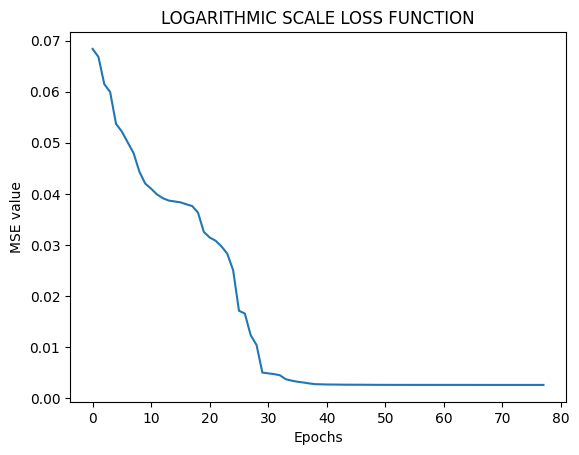

In [7]:
# Plot the loss convergence per epoch in logarithmic scale
loss_convergence = np.array(loss_values)
plt.plot(np.log(loss_convergence + 1))
plt.title('LOGARITHMIC SCALE LOSS FUNCTION')
plt.xlabel('Epochs')
plt.ylabel('MSE value')
plt.show()

### 5.3. QNN training results

Here, the real function is visualized along with the predictions made by the QNN comparing the expected and obtained results.

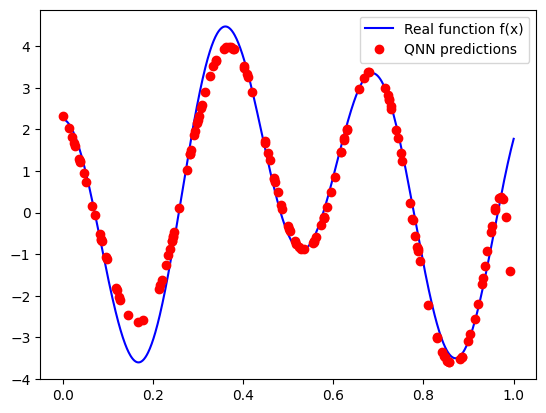

In [8]:
# Evaluate the trained QNN model with the input set
obtained_outputs = np.zeros((dataset_size))
for idx in range(dataset_size):
    obtained_outputs[idx] = evaluate_qnn(input_set[idx], opt_parameters, N_qubits, observable)

# Generate many samples of the original target function
real_fun_samples = 1000
real_fun_in, real_fun_out, real_out_norm = generate_linear_dataset(real_fun_samples, lower_bound, upper_bound)
dataset_min = np.min(obtained_outputs)

# Plot the expected and obtained outcomes restoring to the non-normalized values
plt.plot(real_fun_in, real_fun_out*dataset_norm, 'b', label='Real function f(x)')    
plt.plot(input_set, obtained_outputs*real_out_norm, 'ro', label='QNN predictions')
plt.legend()
plt.show()

### 5.4. QNN testing

A testing random dataset is generated and evaluated to validate the model fitting.

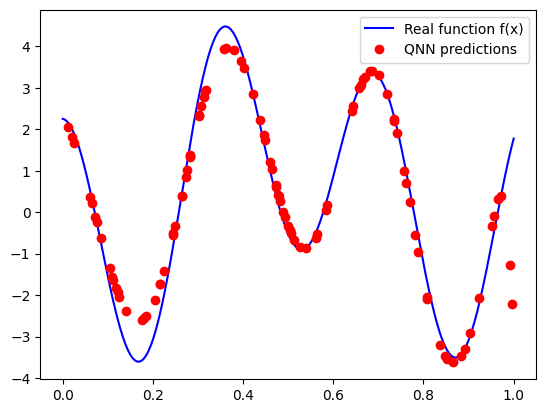

In [9]:
# Create a dataset of the target function with the corresponding range and number of samples
testing_dataset_size = 100
input_test_set, output_test_set, testing_dataset_norm = generate_random_dataset(testing_dataset_size, lower_bound, upper_bound)

# Evaluate the QNN with the testing set
obtained_test_outputs = np.zeros((testing_dataset_size))
for idx in range(testing_dataset_size):
    obtained_test_outputs[idx] = evaluate_qnn(input_test_set[idx], opt_parameters, N_qubits, observable)
    
# Plot the expected and obtained outcomes restoring to the non-normalized values
plt.plot(real_fun_in, real_fun_out*dataset_norm, 'b', label='Real function f(x)')    
plt.plot(input_test_set, obtained_test_outputs*testing_dataset_norm, 'ro', label='QNN predictions')
plt.legend()
plt.show()

## 6. Maximizing output value

Lastly, we create an auxiliary function embedding the QNN evaluation method and negating its result in order to transform the maximization problem into a minimization problem and, then, be able to utilize the minimization function from SciPy. Now, the tunable parameter is the input parameter $x$ and it has one constraint: $x \in [0,1]$.

In [10]:
def callback_max(xk):
    '''
    Function storing current maximum value found 
    for every epoch in the optimization.
    
    :param xk: Current values of tunable parameters
    '''
    e = -maxim_output(xk)
    max_candidates.append(e)

def negate_qnn_evaluation(x, parameters, N_qubits, observable):
    '''
    Negates the evaluation of the QNN with the given parameters allowing the 
    maximization of the output using a minimization optimizer.
    
    :param x: Input value of the QNN
    :param parameters: Tunable parameters of the QNN
    :param N_qubits: Number of qubits in the quantum circuit of the QNN
    :param observable: Observable whose expectation value is to be calculated at the end of the circuit
    :return: Negated expectation value of the observable over the final state of the circuit
    '''
    return -evaluate_qnn(x[0], parameters, N_qubits, observable)

To avoid local maximums, we use _basinhopping_ method that also uses _minimize_ method but making some additional jumps in the input value. This way, the global maximum is eventually reached unlike using the _minimize_ method directly.

=== INPUT MAXIMIZING THE OUTPUT ===
0.3675496058661746
=== MAXIMUM OUTPUT VALUE ===
3.9878797955546545


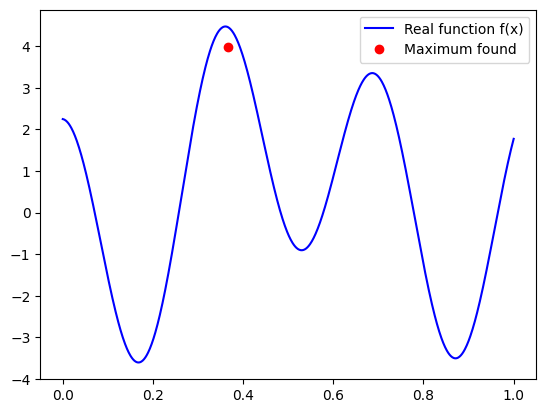

In [11]:
# Define initial input value (random)
x = np.random.rand()

# Define a list for the different maximum values reached
max_candidates = []

# Create a partial function fixing the parameters that are not tunable
maxim_output = partial(negate_qnn_evaluation, parameters=opt_parameters,
                       N_qubits=N_qubits, observable=observable)

# Define optimizer settings
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": opt.Bounds(0, 1), "callback": callback_max}

# Call the hopping method with the defined optimizer to find the maximum output using the trained QNN model
maxim_result = opt.basinhopping(maxim_output, x, minimizer_kwargs=minimizer_kwargs)

input_maximizing = maxim_result.x[0]
print('=== INPUT MAXIMIZING THE OUTPUT ===')
print(input_maximizing)

# Evaluate the model with the optimized input to verify that gives the maximum value
maximized_output = evaluate_qnn(input_maximizing, opt_parameters, N_qubits, observable)
print('=== MAXIMUM OUTPUT VALUE ===')
print(maximized_output*dataset_norm)

# Plot the real function and the maximum found
plt.plot(real_fun_in, real_fun_out*dataset_norm, 'b', label='Real function f(x)')
plt.plot(input_maximizing, maximized_output*dataset_norm, 'ro', label='Maximum found')
plt.legend()
plt.show()

In addition, we can visualize the maximum values found along the _basinhopping_ optimization process.

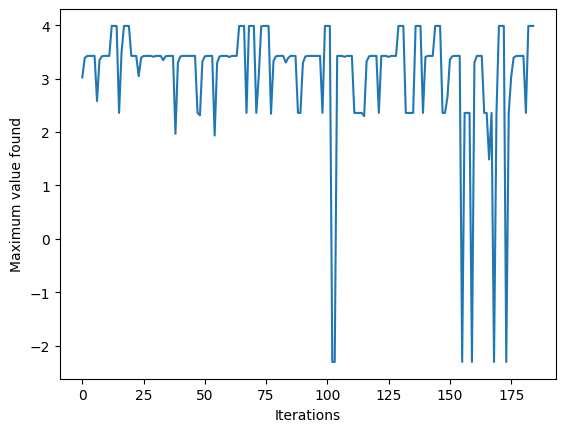

In [12]:
plt.plot(np.array(max_candidates)*dataset_norm)
plt.xlabel('Iterations')
plt.ylabel('Maximum value found')
plt.show()